### Libraries and descritivo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.calibration import calibration_curve
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

from obiwan import *

pd.set_option('display.max_columns', None)

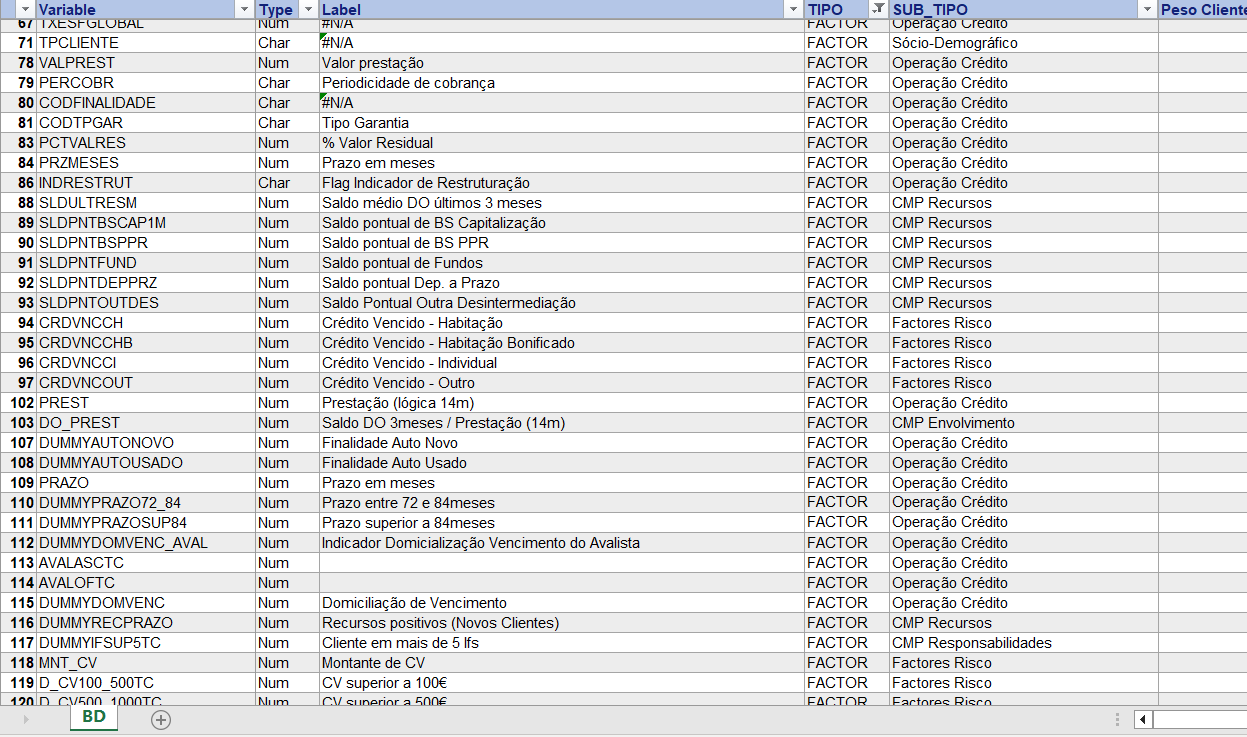

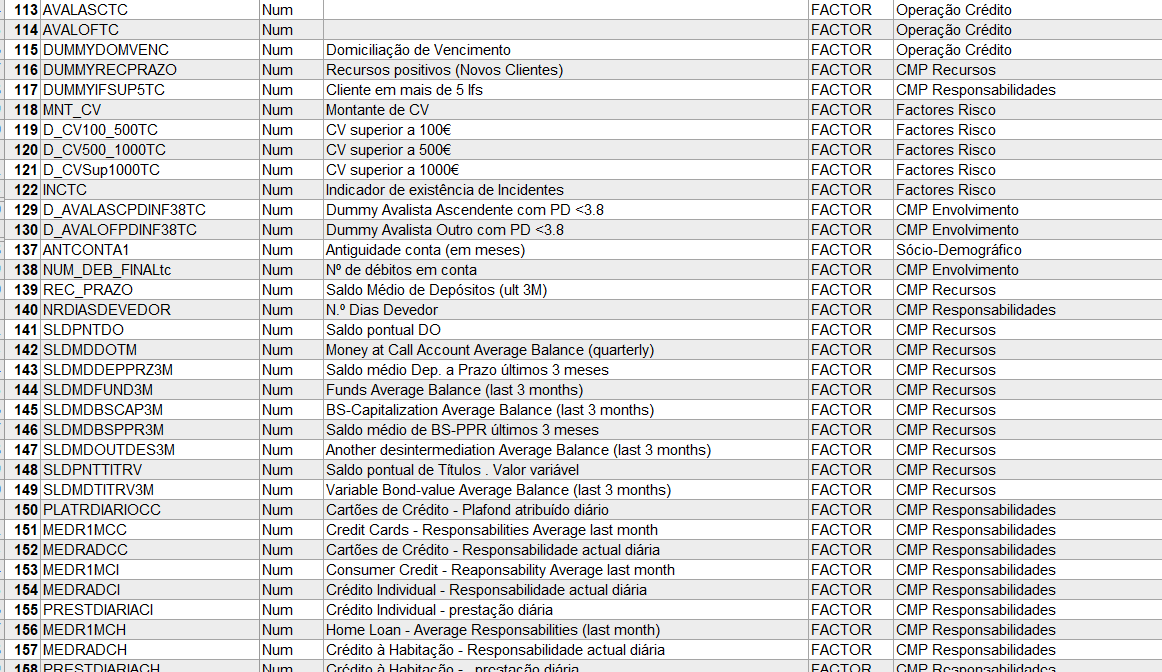

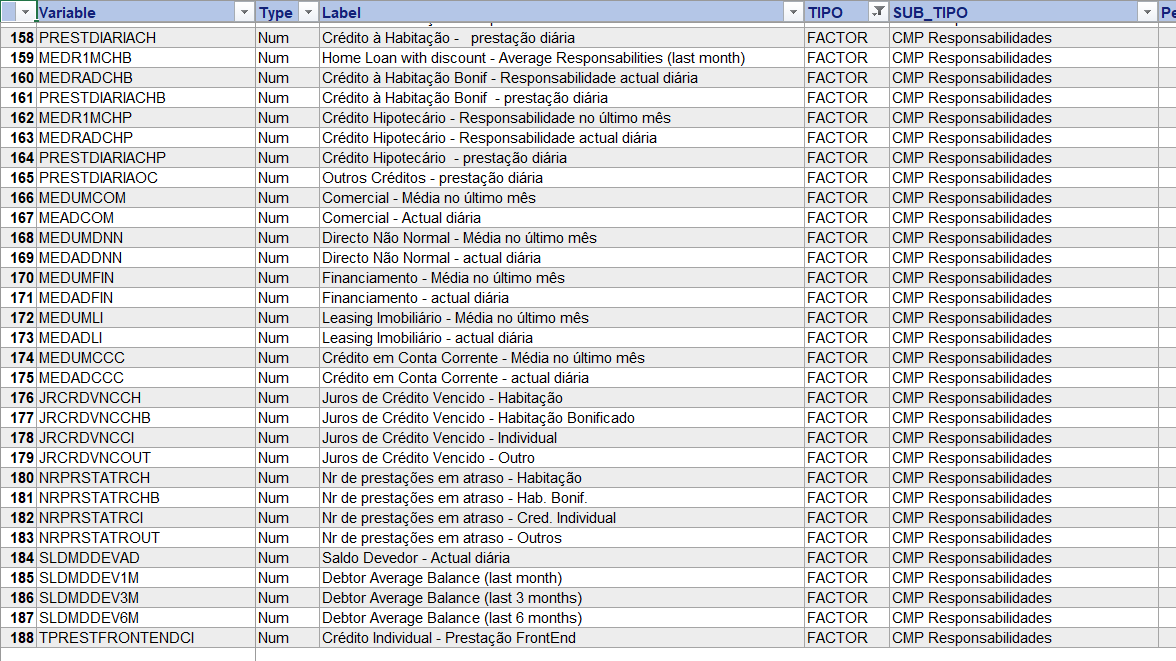

# Functions

In [100]:
# Calcular PowerStat (Kolmogorov-Smirnov Statistic)
def calculate_power_stat(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    ks_statistic = max(tpr - fpr)
    return ks_statistic * 100

# Avaliar o poder discriminatório por variável
def power_stat_by_feature(X, y, model):
    feature_power_stats = {}
    for feature in X.columns:
        X_feature = X[[feature]]
        model.fit(X_feature, y)
        y_pred_proba = model.predict_proba(X_feature)[:, 1]
        power_stat = calculate_power_stat(y, y_pred_proba)
        feature_power_stats[feature] = "{:.2f}".format(power_stat)

    return feature_power_stats


# Teste de Calibração Visual
def plot_calibration_curve(y_true, y_pred_proba, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_pred_proba, n_bins=n_bins)
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('Predicted probability')
    plt.ylabel('True probability')
    plt.title('Calibration Curve')
    plt.show()

def jeffreys_test(y_true, y_pred_proba, threshold=0.5):
    pred = (y_pred_proba >= threshold).astype(int)
    confusion_matrix = pd.crosstab(y_true, pred)
    test_statistic, p_value = stats.chi2_contingency(confusion_matrix)[:2]
    return p_value


# Teste de Grau de Escala (exemplo: comparando predições acima/abaixo de 0.5)
def scale_test(y_true, y_pred_proba, threshold=0.5):
    groups = y_pred_proba > threshold
    group_means = [np.mean(y_pred_proba[groups == g]) for g in np.unique(groups)]
    return np.std(group_means)


# Índice de Estabilidade de População (PSI)
def calculate_psi(expected, actual, buckettype='bins', buckets=10):
    def scale_range (input, min, max):
        input += -(np.min(input))
        input /= np.max(input) / (max - min)
        input += min
        return input
    
    breakpoints = np.linspace(0, 1, buckets + 1)

    expected_percents = np.histogram(expected, bins=breakpoints)[0] / len(expected)
    actual_percents = np.histogram(actual, bins=breakpoints)[0] / len(actual)
    
    psi_value = np.sum((actual_percents - expected_percents) * np.log(actual_percents / expected_percents))
    return psi_value

# Análise

In [104]:
df = pd.read_csv('_T1_AMOSTRA_CI.csv', sep=';')

df['DTREF'] = pd.to_datetime(df['DTREF'])

target = "DEF_12"

df["TPCLIENTE"].value_counts()

TPCLIENTE
S    164859
N     15043
Name: count, dtype: int64

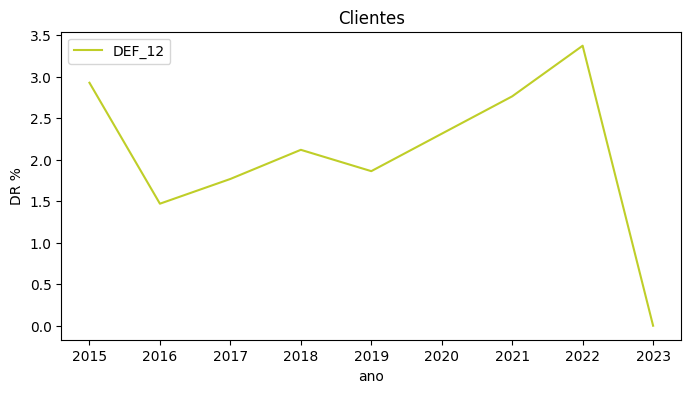

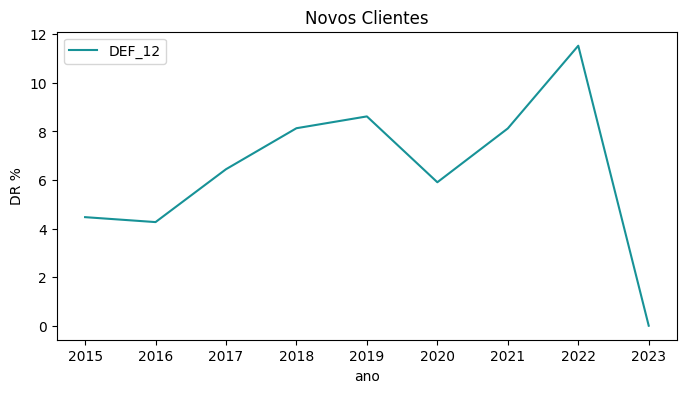

In [105]:
df['ano'] = df['DTREF'].dt.year

percent_default_por_ano = df[df['TPCLIENTE'] == 'S'].groupby('ano')['DEF_12'].mean() * 100

percent_default_por_anoz = df[df['TPCLIENTE'] == 'N'].groupby('ano')['DEF_12'].mean() * 100

pd.DataFrame(percent_default_por_ano).plot(kind='line', ylabel='DR %', figsize=(8,4), title='Clientes', color=nb_default_color2);
pd.DataFrame(percent_default_por_anoz).plot(kind='line', ylabel='DR %', figsize=(8,4), title='Novos Clientes', color=nb_default_color1);

In [106]:
df.head(5)

,ANO,MES,DTREF,TIMEID,CDENTIDADE,IDRFME,CDTIPES,SEGRISCO,STATUS_12,DEF_12,DT_DEF12,DT_CUR12,APLEMI,IDVP,EXPOSICAO,MTLINHASDISP,MTDVINCTOT,MTDVENCTOT,MTDPERDIDOTOT,DTSCORE,CFSCORE,HISTID,IDSCORECRD,MODELO,DEF_24m,DEF_36m,DEF_48m,IDRBES,DT_INICIO,DT_FIM_UTIL,PRAZO_AMORT,COD_SIT,CDFAM,COD_PROD,CDTPRD,IDPS,FINALIDADE,FLAG_EMP,FLAG_REEST,BALCAO,NUMCNT,SCORINGCIID_HIST,FLAG_DEF15,FLAG_DEF18,FLAG_DEF21,FLAG_DEF24,SCR_MARITAL_STATUS,SCR_HABIT,SCR_LEVEL_STUDIES_AGE,SCR_PROFFESION,SCR_TYPE_CONTR,SCR_SDO3M_PREST_PRE,SCR_REC_PRZ,SCR_OP_CRED_PRE,SCR_SD,SCR_ANT,SCR_DIAS_SLD_DEV,SCR_OP_CRED_POS,SCR_SDO3M_PREST_POS,G14,G15,SCR_NUM_DEB,SCR_SLD_PONT,SCR_REC_1500,SCR_AGE,G20,TXESFGLOBAL,OBSERV16,SCOREA,SCOREB,TPCLIENTE,TIPOINTERV,CLASSEINTERV,FLG14PREST,OUT_VALPREST,INVALPRESTDUPLA,OUTVALPRESTDUPLA,VALPREST,PERCOBR,CODFINALIDADE,CODTPGAR,CARNUM,PCTVALRES,PRZMESES,DTPROC,INDRESTRUT,OBSERV10,SLDULTRESM,SLDPNTBSCAP1M,SLDPNTBSPPR,SLDPNTFUND,SLDPNTDEPPRZ,SLDPNTOUTDES,CRDVNCCH,CRDVNCCHB,CRDVNCCI,CRDVNCOUT,VALPRESTDUPLA,PREST_PERCOB,PREST_DUP,PREST_OUT,PREST,DO_PREST,SCR_SDO3M_PREST,SCR_OP_CRED,SCR_INICIAL,DUMMYAUTONOVO,DUMMYAUTOUSADO,PRAZO,DUMMYPRAZO72_84,DUMMYPRAZOSUP84,DUMMYDOMVENC_AVAL,AVALASCTC,AVALOFTC,DUMMYDOMVENC,DUMMYRECPRAZO,DUMMYIFSUP5TC,MNT_CV,D_CV100_500TC,D_CV500_1000TC,D_CVSup1000TC,INCTC,SCR1TC,ZCR1TC,PDTC,INC_AVAL,PD_ASC,PD_OF,D_AVALASCPDINF38TC,D_AVALOFPDINF38TC,SCR2TC,ZCR2TC,SCR3TC,ZCR3TC,SCR_FINAL,FLAG_UNS,ANTCONTA1,NUM_DEB_FINALtc,REC_PRAZO,NRDIASDEVEDOR,SLDPNTDO,SLDMDDOTM,SLDMDDEPPRZ3M,SLDMDFUND3M,SLDMDBSCAP3M,SLDMDBSPPR3M,SLDMDOUTDES3M,SLDPNTTITRV,SLDMDTITRV3M,PLATRDIARIOCC,MEDR1MCC,MEDRADCC,MEDR1MCI,MEDRADCI,PRESTDIARIACI,MEDR1MCH,MEDRADCH,PRESTDIARIACH,MEDR1MCHB,MEDRADCHB,PRESTDIARIACHB,MEDR1MCHP,MEDRADCHP,PRESTDIARIACHP,PRESTDIARIAOC,MEDUMCOM,MEADCOM,MEDUMDNN,MEDADDNN,MEDUMFIN,MEDADFIN,MEDUMLI,MEDADLI,MEDUMCCC,MEDADCCC,JRCRDVNCCH,JRCRDVNCCHB,JRCRDVNCCI,JRCRDVNCOUT,NRPRSTATRCH,NRPRSTATRCHB,NRPRSTATRCI,NRPRSTATROUT,SLDMDDEVAD,SLDMDDEV1M,SLDMDDEV3M,SLDMDDEV6M,TPRESTFRONTENDCI,ano
0,2015,1,2015-01-31,201501,7,AA60013664280,P,1.0,0,0,NaN,NaN,18,104,2286.20,0.0,2286.20,0.0,0,2015-01-11,76.276176,3842362.0,140.0,CI ORG,0,0,0,1106000444,01AUG2014,01AUG2014,36,22,CR006,9821000,CR011,104,98.0,0,0,B1106,1045,3842362.0,0,0,0,0,-90.059875,38.910506,8.541438,84.257327,-65.372035,147.145091,-19.378890,-28.182432,62.271945,69.435340,33.80929,0.0,0.0,0.0,0.0,27.56883,0.0,0.0,151.659911,0.0,21.081,76.276176,247.300836,247.300836,S,T,1.0,N,0.0,0.0,0.0,86.57,M,98.0,10.0,0,0.0,36.0,2014-07-25,0.0,5.0,1408.000000,0.0,0.00,0.0,330.09,0.0,0.0,0.0,0.0,0.0,0.0,86.57,0.0,86.57,86.57,1626.429479,147.145091,-28.182432,47.808469,0,0,36.0,0,0,0,NaN,NaN,1,1,0,0.0,0,0,0,0,69.042649,104.432914,0.002763,0,NaN,NaN,0,0,104.432914,104.048869,98.780901,76.276176,76.276176,0,174.0,34.0,261.333333,0.0,1536.95,1189.333333,261.333333,0.0,0.0,0.000000,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,7570.175000,7438.81,127.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,2015
1,2015,1,2015-01-31,201501,7,AA60013664281,P,1.0,0,0,NaN,NaN,18,104,9660.92,0.0,9660.92,0.0,0,2015-01-11,-47.461449,3824355.0,140.0,CI ORG,0,0,0,556000374,01AUG2014,01AUG2014,72,20,CR006,9821100,CR011,104,98.0,0,0,B0556,921,3824355.0,0,0,0,0,-55.858839,-52.863923,-91.061569,-26.471640,24.849190,-28.451355,-20.528206,-37.244259,-75.026320,-56.965861,33.80929,0.0,0.0,0.0,0.0,27.56883,0.0,0.0,-31.988218,0.0,25.736,-47.461449,144.104357,144.104357,S,T,1.0,N,0.0,0.0,0.0,195.16,M,98.0,11.0,0,0.0,72.0,2014-07-11,0.0,5.0,94.333333,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,195.16,0.0,195.16,195.16,48.336408,-28.451355,-37.244259,-40.544658,0,0,72.0,0,0,0,NaN,NaN,1,0,0,0.0,0,0,0,0,-19.310478,-31.900756,0.037089,0,NaN,0.041983,0,0,-31.900756,-32.879847,-27.878162,-47.461449,-47.461449,0,18.0,13.0,0.000000,0.0,172.43,50.666667,0.000000,0.0,0.0,0.000000,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

# Model 1

In [107]:
df = pd.read_csv('_T1_AMOSTRA_CI.csv', sep=';')

df['DTREF'] = pd.to_datetime(df['DTREF'])

target = "DEF_12"

cols1 = ["DTREF",
     "SCR_MARITAL_STATUS", "SCR_AGE", "SCR_LEVEL_STUDIES_AGE", "SCR_HABIT", "SCR_TYPE_CONTR", "SCR_PROFFESION",
     "SCR_OP_CRED_POS",	"SCR_SDO3M_PREST_POS", "SCR_REC_PRZ", "SCR_ANT", "SCR_NUM_DEB", "SLDULTRESM", "VALPREST",
     "SCR_DIAS_SLD_DEV", target
            ]

df1 = df[cols1].dropna()

df1['SaldoDO3M/Prest'] = df1["SLDULTRESM"] / df1["VALPREST"]

df1 = df1.drop(columns=["SLDULTRESM", "VALPREST"])

In [108]:
df_train = df1[df1['DTREF'] <= '2021-12-31'] # ensino o modelo a prever
df_test = df1[df1['DTREF'] > '2021-12-31'] # testar se ele aprendeu bem

X_train = df_train.drop(columns=['DTREF', target])
y_train = df_train[target]

X_test = df_test.drop(columns=['DTREF', target])
y_test = df_test[target]

from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f'Antes do SMOTE: {y_train.value_counts()}')
print(f'Depois do SMOTE: {y_train_smote.value_counts()}')

Antes do SMOTE: DEF_12
0    131931
1      3447
Name: count, dtype: int64
Depois do SMOTE: DEF_12
0    131931
1     65965
Name: count, dtype: int64


In [109]:
X_train

,SCR_MARITAL_STATUS,SCR_AGE,SCR_LEVEL_STUDIES_AGE,SCR_HABIT,SCR_TYPE_CONTR,SCR_PROFFESION,SCR_OP_CRED_POS,SCR_SDO3M_PREST_POS,SCR_REC_PRZ,SCR_ANT,SCR_NUM_DEB,SCR_DIAS_SLD_DEV,SaldoDO3M/Prest
0,-90.059875,151.659911,8.541438,38.910506,-65.372035,84.257327,0.0,0.0,-19.378890,69.435340,27.56883,33.80929,16.264295
1,-55.858839,-31.988218,-91.061569,-52.863923,24.849190,-26.471640,0.0,0.0,-20.528206,-56.965861,27.56883,33.80929,0.483364
2,36.351348,-31.988218,-44.389051,38.910506,24.849190,27.606819,0.0,0.0,-19.536717,-57.424265,27.56883,-3.26843,2.061806
3,36.351348,-10.530334,8.541438,-52.863923,24.849190,-26.471640,0.0,0.0,-12.880037,102.914087,-138.46291,33.80929,4.138581
4,-90.059875,-10.530334,8.541438,38.910506,24.849190,-26.471640,0.0,0.0,-20.528206,34.252206,27.56883,33.80929,5.864926
...,...,...,...,...,...,...,...,...,...,...,...,...,...
137410,-55.858839,-31.988218,-44.389051,-52.863923,24.849190,67.542813,0.0,0.0,-20.528206,-22.839008,27.56883,33.80929,1.587544
137411,36.351348,-10.530334,8.541438,38.910506,24.849190,-26.471640,0.0,0.0,-20.528206,-55.449930,27.56883,33.80929,0.000000
137412,52.128071,0.000000,95.201764,-72.027945,26.777569,62.412996,0.0,0.0,0.000000,0.000000,0.00000,16.54106,0.000000
137413,52.128071,0.000000,14.989169,-39.107625,26.777569,-28.286069,0.0,0.0,0.000000,0.000000,0.00000,16.54106,0.000000


In [110]:
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

param_grid = {
    'penalty': ['l2', 'l1'],  # Tipo de regularização (L1 ou L2)
    'C': [0.1, 1, 10, 100, 1000],  # Parâmetro de regularização
    'solver': ['liblinear', 'saga'],  # Algoritmos para otimização
    'max_iter': [100, 200, 300]  
}


param_dist = {
    'penalty': ['l2', 'l1'], 
    'C': np.logspace(-4, 4, 20),  # Valores de C variando de 10^-4 a 10^4
    'solver': ['liblinear', 'saga'], 
    'max_iter': [100, 200, 300]  
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model = LogisticRegression()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)
print("Melhores parâmetros encontrados: ", grid_search.best_params_)
best_model = grid_search.best_estimator_

#random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=100, cv=cv, scoring='roc_auc', n_jobs=-1, random_state=42)
#random_search.fit(X_train_smote, y_train_smote)
#print("Melhores parâmetros encontrados: ", random_search.best_params_)
#best_model = random_search.best_estimator_

Melhores parâmetros encontrados:  {'C': 10, 'max_iter': 300, 'penalty': 'l2', 'solver': 'saga'}


Recall: 0.35
F1-Score: 0.1082
AUC-ROC: 0.7692

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.94     43601
           1       0.06      0.35      0.11       923

    accuracy                           0.88     44524
   macro avg       0.52      0.62      0.52     44524
weighted avg       0.97      0.88      0.92     44524

PowerStat: 42.01
PowerStat por feature: {'SCR_MARITAL_STATUS': '15.06', 'SCR_AGE': '16.86', 'SCR_LEVEL_STUDIES_AGE': '13.34', 'SCR_HABIT': '25.70', 'SCR_TYPE_CONTR': '2.61', 'SCR_PROFFESION': '12.17', 'SCR_OP_CRED_POS': '0.01', 'SCR_SDO3M_PREST_POS': '0.01', 'SCR_REC_PRZ': '12.84', 'SCR_ANT': '32.58', 'SCR_NUM_DEB': '24.94', 'SCR_DIAS_SLD_DEV': '29.27', 'SaldoDO3M/Prest': '28.94'}
Jeffrey's Test p-value: 1.631203409353902e-116
Teste de Grau de Escala: 0.191


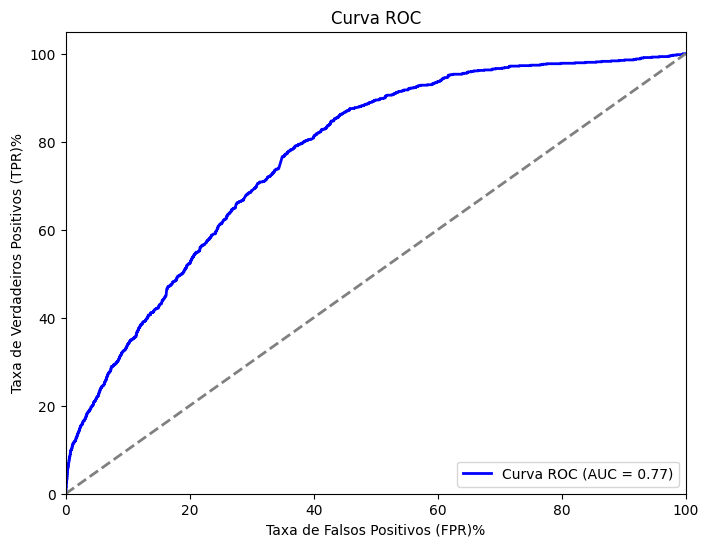

In [111]:
#model = LogisticRegression() 

best_model.fit(X_train_smote, y_train_smote)

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.4f}')
print(f'AUC-ROC: {roc_auc:.4f}')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

power_stat = calculate_power_stat(y_test, y_pred_proba)
print(f'PowerStat: {power_stat:.2f}')

feature_power_stats = power_stat_by_feature(X_test, y_test, best_model)
print("PowerStat por feature:", feature_power_stats)

#plot_calibration_curve(y_test, y_pred_proba)

jeffreys_p_value = jeffreys_test(y_test, y_pred_proba)
print(f"Jeffrey's Test p-value: {jeffreys_p_value}")

scale_stat = scale_test(y_test, y_pred_proba)
print(f"Teste de Grau de Escala: {scale_stat:.3f}")

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr*100, tpr*100, color='b', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 100], [0, 100], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 100])
plt.ylim([0.0, 105])
plt.xlabel('Taxa de Falsos Positivos (FPR)%')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)%')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

In [35]:
y_pred.mean() * 100

33.39322612523583

In [34]:
y_test.mean() * 100

5.3342017788159195

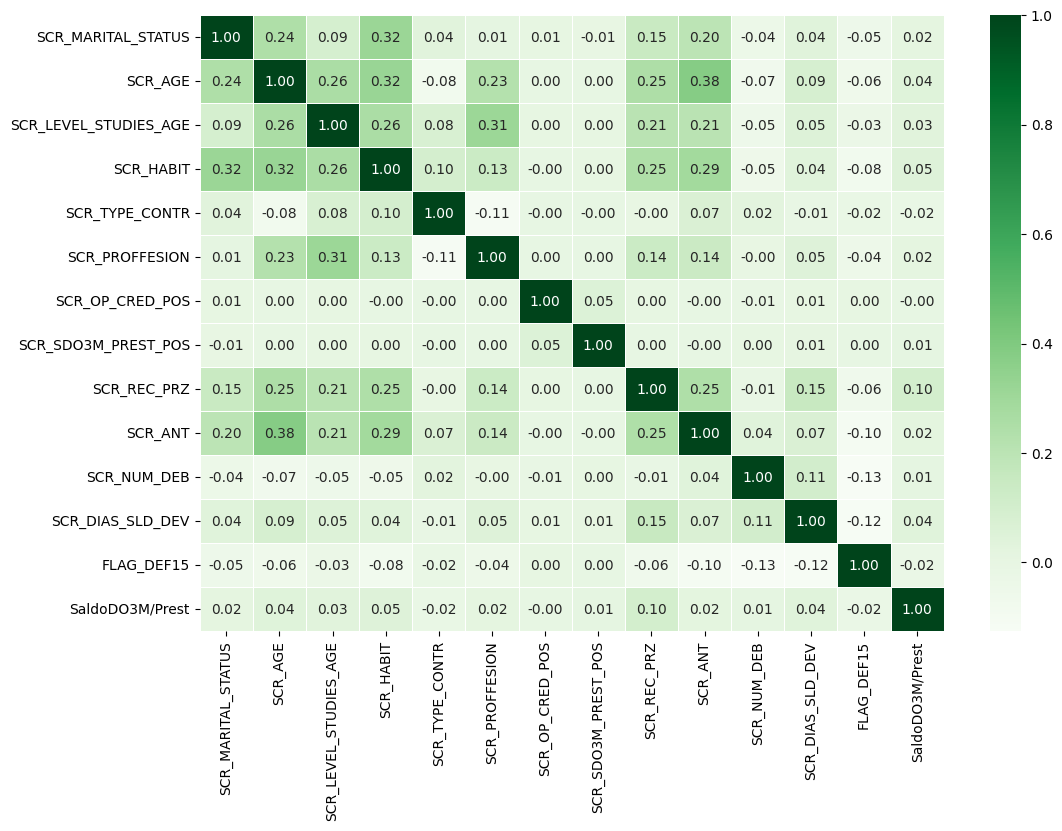

In [62]:
plot_corr_matrix(df1.drop(columns=['DTREF']), figsize=(12,8))

# Modelo novos clientes

In [ ]:
df = pd.read_csv('_T1_AMOSTRA_CI.csv', sep=';')

df['DTREF'] = pd.to_datetime(df['DTREF'])

target = "DEF_12"

dfn = df[df['TPCLIENTE'] == 'S']

In [280]:
#df = pd.read_csv('_T1_AMOSTRA_CI.csv', sep=';')
#df.head(1)

In [281]:
#df['SCR_DIAS_SLD_DEV'].value_counts()

# First intuition

In [208]:
desc = pd.read_excel('T1_CI_ORG_Data_Gathering_v1.0.xlsx')

variable = 'SCR_DIAS_SLD_DEV'

desc[desc['Variable'] == variable]

,#,Variable,Type,Len,Format,Informat,Label,TIPO,SUB_TIPO,Peso Clientes,Peso NC,Rácios,Notas,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
56,57,SCR_DIAS_SLD_DEV,Num,8,17.6,17.6,G11,SCORE,SCORE_OUTPUTS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [191]:
drop_cols = ['TIMEID', 'CDENTIDADE', 'IDRFME', 'APLEMI', 'IDVP', 'DTSCORE', 'HISTID', 'IDSCORECRD', 'MODELO',
             'DEF_24m',	'DEF_36m',	'DEF_48m',	'IDRBES', 'COD_SIT', 'COD_PROD', 'BALCAO', 'NUMCNT', 'IDPS',
             'FLAG_DEF18', 'FLAG_DEF21', 'FLAG_DEF24', 'STATUS_12', 'DEF_12', 'DT_DEF12', 'DT_CUR12',
             'DT_INICIO', 'DT_FIM_UTIL',
            'ANO', 'MES' , 'DTREF']
            # MODELO? TENHO QUE FAZER FILTRO?

df = pd.read_csv('_T1_AMOSTRA_CI.csv', sep=';').drop(columns=drop_cols)

#df.head()

df = data.copy()

X = df.drop('FLAG_DEF15', axis=1)
y = df['FLAG_DEF15']

numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

correlations = X[numerical_cols].corrwith(y).abs().sort_values(ascending=False)

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

mutual_info = mutual_info_classif(X[categorical_cols], y, discrete_features=True)

mutual_info_df = pd.DataFrame({
    'Feature': categorical_cols,
    'Correlation with FLAG_DEF15': mutual_info
}).set_index('Feature')

correlation_df = pd.DataFrame(correlations, columns=['Correlation with FLAG_DEF15'])
combined_df = pd.concat([correlation_df, mutual_info_df], axis=0).sort_values(by='Correlation with FLAG_DEF15', ascending=False)

combined_df 

,Correlation with FLAG_DEF15
NRPRSTATRCH,0.378905
NRPRSTATRCI,0.328920
PDTC,0.198943
JRCRDVNCCH,0.189924
SCOREB,0.186837
...,...
MEADCOM,NaN
MEDUMFIN,NaN
MEDUMLI,NaN
MEDADLI,NaN


In [192]:
na_corr_cols = list(combined_df[combined_df['Correlation with FLAG_DEF15'].isna()].index)
na_corr_cols

['MTDPERDIDOTOT',
 'G20',
 'CLASSEINTERV',
 'OUTVALPRESTDUPLA',
 'DUMMYDOMVENC_AVAL',
 'AVALASCTC',
 'AVALOFTC',
 'INC_AVAL',
 'PRESTDIARIAOC',
 'MEDUMCOM',
 'MEADCOM',
 'MEDUMFIN',
 'MEDUMLI',
 'MEDADLI',
 'NRPRSTATROUT']

In [193]:
combined_df.dropna().head(50)

,Correlation with FLAG_DEF15
NRPRSTATRCH,0.378905
NRPRSTATRCI,0.328920
PDTC,0.198943
JRCRDVNCCH,0.189924
SCOREB,0.186837
SCOREA,0.186803
D_CVSup1000TC,0.181486
SCR3TC,0.174923
INDRESTRUT,0.166205
CFSCORE,0.166184


In [194]:
features = list(combined_df.dropna().head(50).index)
#features

<Axes: >

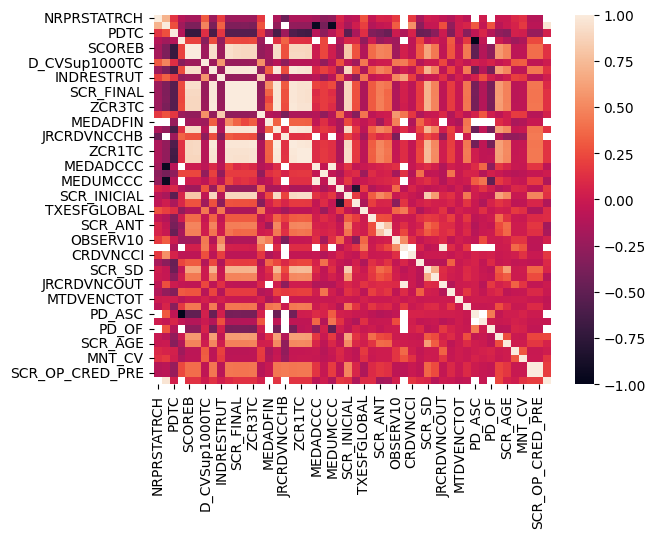

In [195]:
sns.heatmap(df[features].corr())

In [188]:
desc[~desc['Label'].isna()]['Variable'].unique()

array(['SCORINGCIID_HIST', 'SCR_MARITAL_STATUS', 'SCR_HABIT',
       'SCR_LEVEL_STUDIES_AGE', 'SCR_PROFFESION', 'SCR_TYPE_CONTR',
       'SCR_SDO3M_PREST_PRE', 'SCR_REC_PRZ', 'SCR_OP_CRED_PRE', 'SCR_SD',
       'SCR_ANT', 'SCR_DIAS_SLD_DEV', 'SCR_OP_CRED_POS',
       'SCR_SDO3M_PREST_POS', 'G14', 'G15', 'SCR_NUM_DEB', 'SCR_SLD_PONT',
       'SCR_REC_1500', 'SCR_AGE', 'TIPOINTERV', 'CLASSEINTERV',
       'FLG14PREST', 'OUT_VALPREST', 'INVALPRESTDUPLA',
       'OUTVALPRESTDUPLA', 'VALPREST', 'PERCOBR', 'CODTPGAR', 'CARNUM',
       'PCTVALRES', 'PRZMESES', 'DTPROC', 'INDRESTRUT', 'OBSERV10',
       'SLDULTRESM', 'SLDPNTBSCAP1M', 'SLDPNTBSPPR', 'SLDPNTFUND',
       'SLDPNTDEPPRZ', 'SLDPNTOUTDES', 'CRDVNCCH', 'CRDVNCCHB',
       'CRDVNCCI', 'CRDVNCOUT', 'PREST', 'DO_PREST', 'SCR_INICIAL',
       'DUMMYAUTONOVO', 'DUMMYAUTOUSADO', 'PRAZO', 'DUMMYPRAZO72_84',
       'DUMMYPRAZOSUP84', 'DUMMYDOMVENC_AVAL', 'DUMMYDOMVENC',
       'DUMMYRECPRAZO', 'DUMMYIFSUP5TC', 'MNT_CV', 'D_CV100_500TC',
    

In [189]:
df = df[['SCORINGCIID_HIST', 'SCR_MARITAL_STATUS', 'SCR_HABIT',
       'SCR_LEVEL_STUDIES_AGE', 'SCR_PROFFESION', 'SCR_TYPE_CONTR',
       'SCR_SDO3M_PREST_PRE', 'SCR_REC_PRZ', 'SCR_OP_CRED_PRE', 'SCR_SD',
       'SCR_ANT', 'SCR_DIAS_SLD_DEV', 'SCR_OP_CRED_POS',
       'SCR_SDO3M_PREST_POS', 'G14', 'G15', 'SCR_NUM_DEB', 'SCR_SLD_PONT',
       'SCR_REC_1500', 'SCR_AGE', 'TIPOINTERV', 'CLASSEINTERV',
       'FLG14PREST', 'OUT_VALPREST', 'INVALPRESTDUPLA',
       'OUTVALPRESTDUPLA', 'VALPREST', 'PERCOBR', 'CODTPGAR', 'CARNUM',
       'PCTVALRES', 'PRZMESES', 'DTPROC', 'INDRESTRUT', 'OBSERV10',
       'SLDULTRESM', 'SLDPNTBSCAP1M', 'SLDPNTBSPPR', 'SLDPNTFUND',
       'SLDPNTDEPPRZ', 'SLDPNTOUTDES', 'CRDVNCCH', 'CRDVNCCHB',
       'CRDVNCCI', 'CRDVNCOUT', 'PREST', 'DO_PREST', 'SCR_INICIAL',
       'DUMMYAUTONOVO', 'DUMMYAUTOUSADO', 'PRAZO', 'DUMMYPRAZO72_84',
       'DUMMYPRAZOSUP84', 'DUMMYDOMVENC_AVAL', 'DUMMYDOMVENC',
       'DUMMYRECPRAZO', 'DUMMYIFSUP5TC', 'MNT_CV', 'D_CV100_500TC',
       'D_CV500_1000TC', 'D_CVSup1000TC', 'INCTC', 'D_AVALASCPDINF38TC',
       'D_AVALOFPDINF38TC', 'FLAG_UNS', 'ANTCONTA1', 'NUM_DEB_FINALtc',
       'REC_PRAZO', 'NRDIASDEVEDOR', 'SLDPNTDO', 'SLDMDDOTM',
       'SLDMDDEPPRZ3M', 'SLDMDFUND3M', 'SLDMDBSCAP3M', 'SLDMDBSPPR3M',
       'SLDMDOUTDES3M', 'SLDPNTTITRV', 'SLDMDTITRV3M', 'PLATRDIARIOCC',
       'MEDR1MCC', 'MEDRADCC', 'MEDR1MCI', 'MEDRADCI', 'PRESTDIARIACI',
       'MEDR1MCH', 'MEDRADCH', 'PRESTDIARIACH', 'MEDR1MCHB', 'MEDRADCHB',
       'PRESTDIARIACHB', 'MEDR1MCHP', 'MEDRADCHP', 'PRESTDIARIACHP',
       'PRESTDIARIAOC', 'MEDUMCOM', 'MEADCOM', 'MEDUMDNN', 'MEDADDNN',
       'MEDUMFIN', 'MEDADFIN', 'MEDUMLI', 'MEDADLI', 'MEDUMCCC',
       'MEDADCCC', 'JRCRDVNCCH', 'JRCRDVNCCHB', 'JRCRDVNCCI',
       'JRCRDVNCOUT', 'NRPRSTATRCH', 'NRPRSTATRCHB', 'NRPRSTATRCI',
       'NRPRSTATROUT', 'SLDMDDEVAD', 'SLDMDDEV1M', 'SLDMDDEV3M',
       'SLDMDDEV6M', 'TPRESTFRONTENDCI', 'FLAG_DEF15']]

df

,SCORINGCIID_HIST,SCR_MARITAL_STATUS,SCR_HABIT,SCR_LEVEL_STUDIES_AGE,SCR_PROFFESION,SCR_TYPE_CONTR,SCR_SDO3M_PREST_PRE,SCR_REC_PRZ,SCR_OP_CRED_PRE,SCR_SD,SCR_ANT,SCR_DIAS_SLD_DEV,SCR_OP_CRED_POS,SCR_SDO3M_PREST_POS,G14,G15,SCR_NUM_DEB,SCR_SLD_PONT,SCR_REC_1500,SCR_AGE,TIPOINTERV,CLASSEINTERV,FLG14PREST,OUT_VALPREST,INVALPRESTDUPLA,OUTVALPRESTDUPLA,VALPREST,PERCOBR,CODTPGAR,CARNUM,PCTVALRES,PRZMESES,DTPROC,INDRESTRUT,OBSERV10,SLDULTRESM,SLDPNTBSCAP1M,SLDPNTBSPPR,SLDPNTFUND,SLDPNTDEPPRZ,SLDPNTOUTDES,CRDVNCCH,CRDVNCCHB,CRDVNCCI,CRDVNCOUT,PREST,DO_PREST,SCR_INICIAL,DUMMYAUTONOVO,DUMMYAUTOUSADO,PRAZO,DUMMYPRAZO72_84,DUMMYPRAZOSUP84,DUMMYDOMVENC_AVAL,DUMMYDOMVENC,DUMMYRECPRAZO,DUMMYIFSUP5TC,MNT_CV,D_CV100_500TC,D_CV500_1000TC,D_CVSup1000TC,INCTC,D_AVALASCPDINF38TC,D_AVALOFPDINF38TC,FLAG_UNS,ANTCONTA1,NUM_DEB_FINALtc,REC_PRAZO,NRDIASDEVEDOR,SLDPNTDO,SLDMDDOTM,SLDMDDEPPRZ3M,SLDMDFUND3M,SLDMDBSCAP3M,SLDMDBSPPR3M,SLDMDOUTDES3M,SLDPNTTITRV,SLDMDTITRV3M,PLATRDIARIOCC,MEDR1MCC,MEDRADCC,MEDR1MCI,MEDRADCI,PRESTDIARIACI,MEDR1MCH,MEDRADCH,PRESTDIARIACH,MEDR1MCHB,MEDRADCHB,PRESTDIARIACHB,MEDR1MCHP,MEDRADCHP,PRESTDIARIACHP,PRESTDIARIAOC,MEDUMCOM,MEADCOM,MEDUMDNN,MEDADDNN,MEDUMFIN,MEDADFIN,MEDUMLI,MEDADLI,MEDUMCCC,MEDADCCC,JRCRDVNCCH,JRCRDVNCCHB,JRCRDVNCCI,JRCRDVNCOUT,NRPRSTATRCH,NRPRSTATRCHB,NRPRSTATRCI,NRPRSTATROUT,SLDMDDEVAD,SLDMDDEV1M,SLDMDDEV3M,SLDMDDEV6M,TPRESTFRONTENDCI,FLAG_DEF15
0,3842362.0,-90.059875,38.910506,8.541438,84.257327,-65.372035,147.145091,-19.378890,-28.182432,62.271945,69.435340,33.80929,0.0,0.0,0.0,0.0,27.56883,0.0000,0.00000,151.659911,T,1.0,N,0.0,0.0,0.0,86.57,M,10.0,0,0.0,36.0,2014-07-25,0.0,5.0,1408.000000,0.0,0.00,0.0,330.09,0.0,0.0,0.0,0.0,0.0,86.57,1626.429479,47.808469,0,0,36.0,0,0,0,1,1,0,0.0,0,0,0,0,0,0,0,174.0,34.0,261.333333,0.0,1536.95,1189.333333,261.333333,0.0,0.0,0.000000,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,7570.175000,7438.81,127.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,0
1,3824355.0,-55.858839,-52.863923,-91.061569,-26.471640,24.849190,-28.451355,-20.528206,-37.244259,-75.026320,-56.965861,33.80929,0.0,0.0,0.0,0.0,27.56883,0.0000,0.00000,-31.988218,T,1.0,N,0.0,0.0,0.0,195.16,M,11.0,0,0.0,72.0,2014-07-11,0.0,5.0,94.333333,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,195.16,48.336408,-40.544658,0,0,72.0,0,0,0,1,0,0,0.0,0,0,0,0,0,0,0,18.0,13.0,0.000000,0.0,172.43,50.666667,0.000000,0.0,0.0,0.000000,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0
2,3823521.0,36.351348,38.910506,-44.389051,27.606819,24.849190,-20.169249,-19.536717,-30.877978,34.860743,-57.424265,-3.26843,0.0,0.0,0.0,0.0,27.56883,0.0000,0.00000,-31.988218,T,1.0,N,0.0,0.0,0.0,69.68,M,10.0,0,0.0,48.0,2014-07-10,0.0,5.0,143.666667,0.0,0.00,0.0,262.40,0.0,0.0,0.0,0.0,0.0,69.68,206.180636,-1.875302,0,0,48.0,0,0,0,0,1,0,0.0,0,0,0,0,0,0,0,16.0,64.0,227.000000,1.0,-472.97,225.333333,227.000000,0.0,0.0,0.000000,0.0,NaN,0.0,150.0,125.489032,0.03,NaN,NaN,NaN,21946.176774,21918.60,110.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,472.97,384.0,171.0,85.5,0.00,0
3,3828480.0,36.351348,-52.863923,8.541438,-26.471640,24.849190,-1.578129,-12.880037,96.712302,-1.255947,102.914087,33.80929,0.0,0.0,0.0,0.0,-138.46291,0.0000,0.00000,-10.530334,T,1.0,N,0.0,0.0,0.0,91.98,M,10.0,0,0.0,48.0,2014-07-15,0.0,5.0,380.666667,0.0,788.76,0.0,800.00,0.0,0.0,0.0,0.0,0.0,91.98,413.858085,3.576804,0,0,48.0,0,0,0,0,1,0,0.0,0,0,0,0,0,0,0,318.0,1.0,1384.943957,0.0,175.46,634.000000,600.000000,0.0,0.0,784.943957,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0
4,3848819.0,-90.059875,38.910506,8.541438,-26.471640,24.849190,22.092354,-20.528206,-39.279673,-30.795297,34.252206,33.80929,0.0,0.0,0.0,0.0,27.56883,0.000

In [190]:
dd = pd.DataFrame(df.isnull().sum())
dd[dd[0] > 0]

,0
SCORINGCIID_HIST,2291
SCR_MARITAL_STATUS,2291
SCR_HABIT,2291
SCR_LEVEL_STUDIES_AGE,2291
SCR_PROFFESION,2291
...,...
SLDMDDEVAD,93350
SLDMDDEV1M,122480
SLDMDDEV3M,116016
SLDMDDEV6M,108067
